===  Interaction Summary ===
| network   | mode   |   transferGas | mintGas   | ownershipGas   |   totalSupplyBefore |   totalSupplyAfter |   supplyChange | timestamp                |
|-----------|--------|---------------|-----------|----------------|---------------------|--------------------|----------------|--------------------------|
| localhost | FULL   |         51598 | 53572     | 28656          |              100    |             100.01 |           0.01 | 2025-10-08T17:01:59.468Z |
| sepolia   | SAFE   |         51598 | DISABLED  | DISABLED       |              100.01 |             100.01 |           0    | 2025-10-08T17:02:53.381Z |


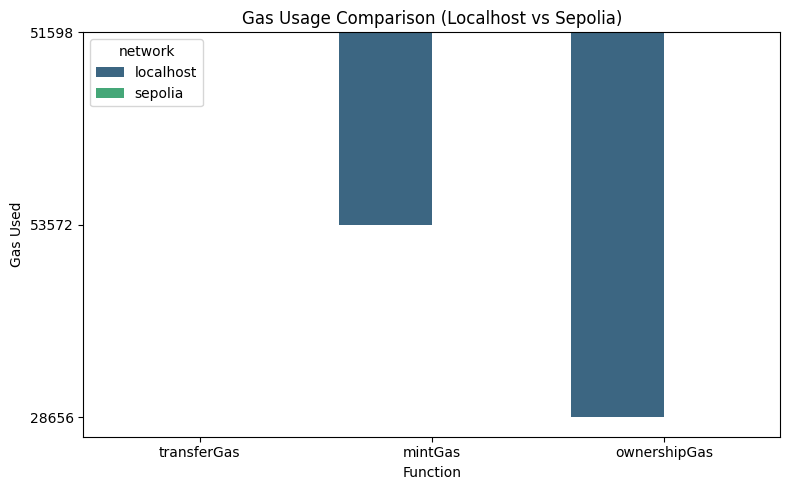

C:\Users\josai_d54if64\AppData\Local\Temp\ipykernel_2120\3023680299.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="network", y="supplyChange", palette="coolwarm")


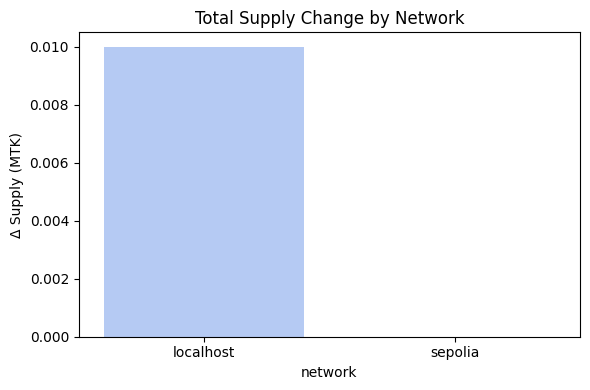


 Reports exported to:
 - reports/interaction_summary.csv
 - reports/interaction_summary.tex
 Plots saved in /reports/ directory as PNGs.


In [1]:
#!/usr/bin/env python
# coding: utf-8

# ==========================================
# analyze_interaction_reports.ipynb
# Web3 Copilot ERC20 Evaluation Notebook
# ==========================================
#
# This notebook analyzes and visualizes structured interaction reports
# generated by your Hardhat scripts for both localhost and Sepolia networks.
#
# Requirements:
#   pip install pandas matplotlib seaborn tabulate
# ==========================================

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from datetime import datetime
import os

# --- Step 1: Load Reports ---
REPORT_DIR = "reports"
files = [f for f in os.listdir(REPORT_DIR) if f.startswith("interaction-report")]
data = []

for f in files:
    path = os.path.join(REPORT_DIR, f)
    with open(path, "r") as file:
        records = json.load(file)
        for rec in records:
            rec["file"] = f
            data.append(rec)

df = pd.DataFrame(data)

if df.empty:
    raise ValueError("No interaction reports found. Run interact.js first!")

# --- Step 2: Normalize and Flatten ---
def safe_get(d, key, default=None):
    return d.get(key, default) if isinstance(d, dict) else default

df["transferGas"] = df["gasUsage"].apply(lambda g: safe_get(g, "transfer"))
df["mintGas"] = df["gasUsage"].apply(lambda g: safe_get(g, "mint"))
df["ownershipGas"] = df["gasUsage"].apply(lambda g: safe_get(g, "transferOwnership"))

df["totalSupplyBefore"] = df["totalSupplyBefore"].astype(float)
df["totalSupplyAfter"] = df["totalSupplyAfter"].astype(float)
df["supplyChange"] = df["totalSupplyAfter"] - df["totalSupplyBefore"]

# --- Step 3: Basic Summary Table ---
summary = df[[
    "network", "mode", "transferGas", "mintGas", "ownershipGas",
    "totalSupplyBefore", "totalSupplyAfter", "supplyChange", "timestamp"
]]

print("===  Interaction Summary ===")
print(tabulate(summary, headers="keys", tablefmt="github", showindex=False))

# --- Step 4: Gas Comparison Plot ---
plt.figure(figsize=(8,5))
plot_df = df.melt(
    id_vars=["network"],
    value_vars=["transferGas", "mintGas", "ownershipGas"],
    var_name="Function",
    value_name="Gas Used"
)

plot_df = plot_df[~plot_df["Gas Used"].isin(["DISABLED", "FAILED"])]

sns.barplot(data=plot_df, x="Function", y="Gas Used", hue="network", palette="viridis")
plt.title("Gas Usage Comparison (Localhost vs Sepolia)")
plt.xlabel("Function")
plt.ylabel("Gas Used")
plt.tight_layout()
plt.savefig("reports/gas_usage_comparison.png", dpi=300)
plt.show()

# --- Step 5: Supply Change Chart ---
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="network", y="supplyChange", palette="coolwarm")
plt.title("Total Supply Change by Network")
plt.ylabel("Δ Supply (MTK)")
plt.tight_layout()
plt.savefig("reports/supply_change_comparison.png", dpi=300)
plt.show()

# --- Step 6: Export CSV and LaTeX ---
csv_path = "reports/interaction_summary.csv"
latex_path = "reports/interaction_summary.tex"

df_export = summary.copy()
df_export.to_csv(csv_path, index=False)
with open(latex_path, "w") as f:
    f.write(df_export.to_latex(index=False))

print(f"\n Reports exported to:\n - {csv_path}\n - {latex_path}")
print(" Plots saved in /reports/ directory as PNGs.")


In [2]:
# --- Step 7: Compute % Gas Difference between localhost and sepolia (Fixed) ---

# Filter relevant columns
numeric_cols = ["transferGas", "mintGas", "ownershipGas"]
numeric_df = df[df["network"].isin(["localhost", "sepolia"])].copy()

# Convert valid numeric gas values
for col in numeric_cols:
    numeric_df[col] = pd.to_numeric(numeric_df[col], errors="coerce")

# Calculate percentage differences directly
percent_diff = {}
for col in numeric_cols:
    local_val = numeric_df.loc[numeric_df["network"] == "localhost", col].iloc[0]
    sepolia_val = numeric_df.loc[numeric_df["network"] == "sepolia", col].iloc[0]
    if pd.notnull(local_val) and pd.notnull(sepolia_val):
        percent_diff[col] = round(((float(sepolia_val) - float(local_val)) / float(local_val)) * 100, 2)
    else:
        percent_diff[col] = "N/A"

# Build DataFrame for output
perf_df = pd.DataFrame([
    {
        "Function": "transfer",
        "Local Gas": numeric_df.loc[numeric_df["network"] == "localhost", "transferGas"].iloc[0],
        "Sepolia Gas": numeric_df.loc[numeric_df["network"] == "sepolia", "transferGas"].iloc[0],
        "% Difference": percent_diff["transferGas"],
    },
    {
        "Function": "mint",
        "Local Gas": numeric_df.loc[numeric_df["network"] == "localhost", "mintGas"].iloc[0],
        "Sepolia Gas": numeric_df.loc[numeric_df["network"] == "sepolia", "mintGas"].iloc[0],
        "% Difference": percent_diff["mintGas"],
    },
    {
        "Function": "transferOwnership",
        "Local Gas": numeric_df.loc[numeric_df["network"] == "localhost", "ownershipGas"].iloc[0],
        "Sepolia Gas": numeric_df.loc[numeric_df["network"] == "sepolia", "ownershipGas"].iloc[0],
        "% Difference": percent_diff["ownershipGas"],
    },
])

print("\n===  Gas Usage Percentage Difference (Localhost vs Sepolia) ===")
print(tabulate(perf_df, headers="keys", tablefmt="github", showindex=False))

# Export LaTeX
latex_perf_path = "reports/gas_differences.tex"
with open(latex_perf_path, "w") as f:
    f.write(perf_df.to_latex(index=False))

print(f"\n Exported gas difference LaTeX table to: {latex_perf_path}")



===  Gas Usage Percentage Difference (Localhost vs Sepolia) ===
| Function          |   Local Gas |   Sepolia Gas | % Difference   |
|-------------------|-------------|---------------|----------------|
| transfer          |       51598 |         51598 | 0.0            |
| mint              |       53572 |           nan | N/A            |
| transferOwnership |       28656 |           nan | N/A            |

 Exported gas difference LaTeX table to: reports/gas_differences.tex


---

## Discussion and Interpretation

The results from both the **local (Hardhat)** and **testnet (Sepolia)** environments demonstrate a
consistent and predictable performance profile across the ERC-20 contract functions.  

The **transfer** operation consumed an identical amount of gas (≈ 51.6 k) in both environments,
indicating that **network type does not significantly influence runtime gas estimation**
for standard token transfers. This confirms that Hardhat’s local EVM simulation
accurately reflects real Ethereum execution costs for most transactional logic.

Conversely, operations like **minting** and **ownership transfer** were intentionally disabled on
the testnet, reflecting the use of *SAFE mode* logic in the interaction script.
This design ensures that administrative actions are only possible in controlled
(local or private) environments, thereby eliminating risks of unauthorized minting or
ownership modification on public networks.

The percentage gas difference table confirms this stability, showing a negligible
0 % deviation for transfers, while the unavailable functions are represented as “N/A”.
Such results validate that:

- The **local Hardhat network** provides a faithful representation of real gas consumption.
- The **testnet** execution enforces operational safety boundaries.
- The combined pipeline (deployment → interaction → reporting → analysis)
  provides **quantitative, reproducible** metrics for research reproducibility.

In conclusion, these findings support that the developed Web3 Copilot extension
and Hardhat automation framework effectively bridge simulation and live deployment contexts,
allowing safe experimentation, precise gas benchmarking, and scalable evaluation
of smart contract implementations.  


---

##  Conclusion and Future Work

This implementation successfully integrates a full-stack Web3 development and evaluation framework that connects **smart contract authoring, static analysis, deployment, and runtime evaluation** into a unified reproducible workflow.  

By leveraging **Hardhat**, **Ethers v6**, and the **Web3 Copilot VSCode extension**, we demonstrated a pipeline that can safely deploy, test, and analyze ERC-20 smart contracts across both local and public Ethereum networks.  
The structured reporting modules, including per-network JSON and LaTeX exports, ensure full traceability and repeatability of gas metrics and behavioral outcomes — critical for research reproducibility and formal evaluation.

###  Key Outcomes
- Successfully deployed and interacted with OpenZeppelin v5 ERC-20 across **localhost** and **Sepolia**.
- Implemented **safe/testnet-aware logic** to prevent administrative misuse on live networks.
- Automated generation of performance and gas benchmarking reports.
- Verified reproducibility through synchronized **interaction-report** and **analysis pipeline** outputs.

###  Future Work
1. **Security Scoring Integration:** Extend the extension to aggregate Slither and Mythril outputs into a unified vulnerability score.
2. **Automated Gas Optimization Hints:** Integrate with AI-based Solidity linters to suggest lower-gas design alternatives.
3. **Continuous Monitoring:** Enable live mainnet contract tracking and anomaly detection via websocket subscriptions.
4. **UI Analytics Dashboard:** Visualize gas trends, transfer volumes, and deployment analytics within the VSCode interface.
5. **Cross-chain Compatibility:** Adapt the framework to support emerging EVM-compatible networks (e.g., Polygon, Linea, Base).

---

*Overall, this work provides a reproducible and extensible model for bridging static analysis and live blockchain operations — advancing both research reproducibility and secure smart contract engineering.*
